In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math


#for statistics
from statistics import mean
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


In [3]:
# read the data into a dataframe
data = pd.read_csv(r'marketing_AB.csv')
data.head(5)

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing

About Dataset
Marketing A/B testing dataset
Marketing companies want to run successful campaigns, but the market is complex and several options can work. So normally they tun A/B tests, that is a randomized experimentation process wherein two or more versions of a variable (web page, page element, banner, etc.) are shown to different segments of people at the same time to determine which version leaves the maximum impact and drive business metrics.

The companies are interested in answering two questions:

Would the campaign be successful?
If the campaign was successful, how much of that success could be attributed to the ads?
With the second question in mind, we normally do an A/B test. The majority of the people will be exposed to ads (the experimental group). And a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be.

The idea of the dataset is to analyze the groups, find if the ads were successful, how much the company can make from the ads, and if the difference between the groups is statistically significant.

Data dictionary:

Index: Row index
user id: User ID (unique)
test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
converted: If a person bought the product then True, else is False
total ads: Amount of ads seen by person
most ads day: Day that the person saw the biggest amount of ads
most ads hour: Hour of day that the person saw the biggest amount of ads

In [4]:
data.describe()

,Unnamed: 0,user id,total ads,most ads hour
count,588101.000000,5.881010e+05,588101.000000,588101.000000
mean,294050.000000,1.310692e+06,24.820876,14.469061
std,169770.279667,2.022260e+05,43.715181,4.834634
min,0.000000,9.000000e+05,1.000000,0.000000
25%,147025.000000,1.143190e+06,4.000000,11.000000
50%,294050.000000,1.313725e+06,13.000000,14.000000
75%,441075.000000,1.484088e+06,27.000000,18.000000
max,588100.000000,1.654483e+06,2065.000000,23.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [6]:
# convert all columns to int64
data['test group'].replace(['ad','psa'],[1,0], inplace = True)
data['converted'].replace([True,False],[1,0], inplace = True)
data['most ads day'].replace(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],[1,2,3,4,5,6,7], inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Unnamed: 0     588101 non-null  int64
 1   user id        588101 non-null  int64
 2   test group     588101 non-null  int64
 3   converted      588101 non-null  int64
 4   total ads      588101 non-null  int64
 5   most ads day   588101 non-null  int64
 6   most ads hour  588101 non-null  int64
dtypes: int64(7)
memory usage: 31.4 MB


Exploratory Analysis

<AxesSubplot:xlabel='most ads hour', ylabel='count'>

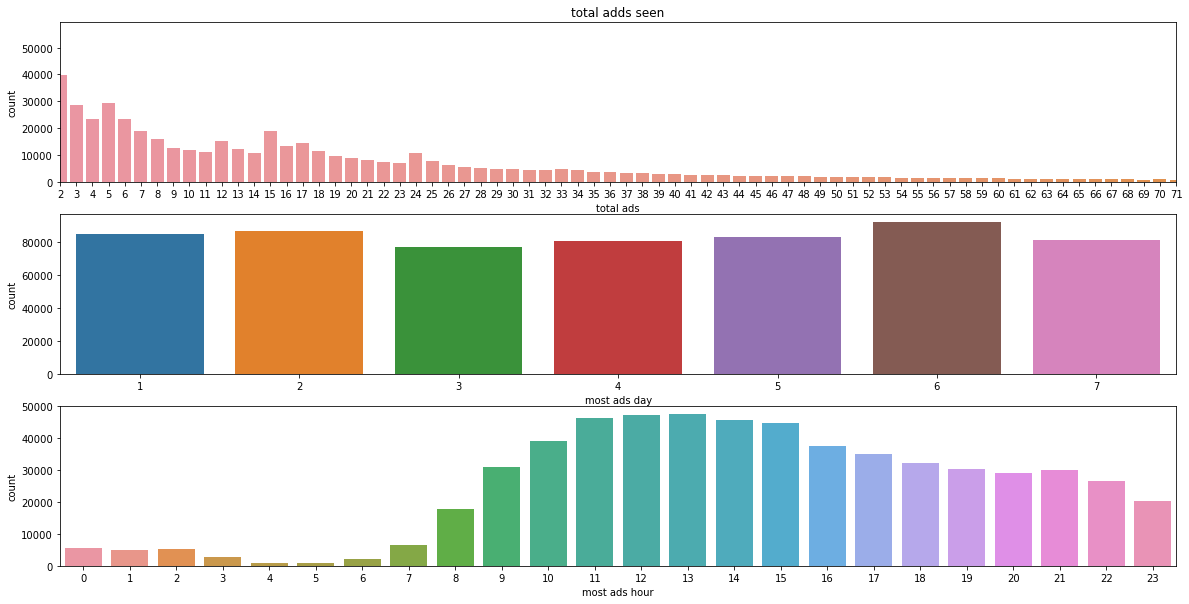

In [7]:
# visualizing distributions of key features

# make these graphs pretty

fig, ax = plt.subplots(3,1, figsize = (20,10))
sns.countplot(ax = ax[0],x = 'total ads', data = data).set(title='total adds seen')
ax[0].set_xlim(1,70)
sns.countplot(ax = ax[1],x = 'most ads day', data = data)
sns.countplot(ax = ax[2],x = 'most ads hour', data = data)



The number of customers who saw more than 71 adds was: 41296 or approximately 7.02 %


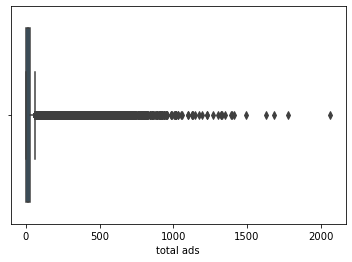

In [8]:

sns.boxplot(data=data, x = 'total ads')
print('The number of customers who saw more than 71 adds was: ' + str(data[data['total ads']>71]['total ads'].count()) + ' or approximately {:0.2f} %'.format(data[data['total ads']>71]['total ads'].count()*100/data['total ads'].count()))

In [9]:
data['test group'].value_counts()

1    564577
0     23524
Name: test group, dtype: int64

In [10]:
print(data.groupby('test group')['converted'].mean())

test group
0    0.017854
1    0.025547
Name: converted, dtype: float64


we can see that the conversion rate for those shown adds is 43% higher than those thown psa's 

In [11]:
# were there any duplicate users?
print(data['user id'].duplicated().sum())
# no duplicates were found


0


Frequentist A/B test
-we will use a two tailed test because we dont know how the ads will effect conversion rate
-H_0: Conversion_no_ads = Conversion_with_Ads
-H_a: Conversion_no_ads != Conversion_with_Ads
- set confidence level at 95% -> alpha = 0.05
- set power level at 0.8 by convention
-

In [12]:
alpha = 0.05
power = 0.8

In [39]:
# determine baseline conversion rate. we will say for the sake of this experiment that we took a random sample of 10,000 instances of customers 
# not shown adds to determine our baseline conversion rate
random.seed(42)
converted_list = (controll_df['converted']).to_list()
baseline_conversion = mean(random.choices(converted_list,k = 10000))
print('The baseline conversion rate is: ' + str(baseline_conversion))

# determine a standard deviation
means = []
for i in range(10000):
    means.append(mean(random.choices(converted_list,k = 10000)))
baseline_std = np.std(means)
print('The baseline standard deviation is: ' + str(baseline_std))

#calculate minimum desired effect size
min_lift = .1
min_effect_size = (baseline_conversion*(1+min_lift)- baseline_conversion)/baseline_std
MDE = baseline_conversion*(1+min_lift)
print('The minimum desirable effect size is: ',min_effect_size)




The baseline conversion rate is: 0.0176
The baseline standard deviation is: 0.0013005671839624435
The minimum desirable effect size is:  1.353255734654016


In [20]:
# sample size calculation
Z_alpha_half = .5987
Z_beta = .7881

n = ((Z_alpha_half*math.sqrt(2*baseline_conversion*(1-baseline_conversion)+Z_beta*math.sqrt(baseline_conversion*(1-baseline_conversion)+MDE*(1-MDE))))**2)/(MDE-baseline_conversion)**2
print('The minimum sample size for this test will be: ',round(n))

The minimum sample size for this test will be:  21371


since our controll group contains 23524 members and our test group is roughly 24x this size we have plenty of observations to conduct this test with the desired accuracy. 

In [42]:
# calculating p- value using ttest_ind
p_val = stats.ttest_ind(list(data[data['test group']==1]['converted']),list(data[data['test group']==0]['converted']), equal_var = True)
print(p_val)

Ttest_indResult(statistic=7.37040597428566, pvalue=1.7033052627831264e-13)


In [46]:
control_results = data[data['test group']==0]['converted']
treatment_results = data[data['test group']==1]['converted']

n_converted = control_results.count()
n_treatment = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_converted, n_treatment]

z_stat, p_val = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treatment), (upper_con, upper_treatment) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print('z statistic: ', z_stat)
print('p-value: ', p_val)
print('95% confidence interval for control group: ' , lower_con, upper_con)
print('95% confidence interval for control group: ' , lower_treatment, upper_treatment)



z statistic:  -7.3700781265454145
p-value:  1.7052807161559727e-13
95% confidence interval for control group:  0.016161914715211324 0.019546298173753137
95% confidence interval for control group:  0.0251349995427061 0.025958119730661394


given that our p- value of 1.7e-13 is far far lower than our significance level of 0.05 we can reject the null hypothesis
This means that our ad campaign had a statistically significant positive impact on conversion rate

Bayesian A/B test 

When and how many of these ads should we run?